# Финальный проект karpov_courses. 

In [36]:
# Импорт библиотек
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm
from scipy.stats import norm
from scipy.stats import chisquare
import scipy
from scipy import stats

# Задание 1. A/B–тестирование

### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

<strong>groups.csv</strong> - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа).<br>
<strong>groups_add.csv</strong> - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.<br>
<strong>active_studs.csv</strong> - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.<br>
<strong>checks.csv</strong> - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

1. На какие метрики Вы смотрите в ходе анализа и почему?<br>
2. Имеются ли различия в показателях и с чем они могут быть связаны?<br>
3. Являются ли эти различия статистически значимыми?<br>
4. Стоит ли запускать новую механику на всех пользователей?

## Предварительный анализ и предобработка данных

In [37]:
# Скачаем датасет groups
url_groups = 'https://disk.yandex.ru/d/LIE6fUfbD7belQ'
groups = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_groups}', sep=';')
print(groups.shape)
groups.head(2)

(74484, 2)


,id,grp
0,1489,B
1,1627,A


In [38]:
# Скачаем датасет groups_add
url_groups_add = 'https://disk.yandex.ru/d/qgQpmgvjemOJFw'
groups_add = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_groups_add}')
print(groups_add.shape)
groups_add.head(2)

(92, 2)


,id,grp
0,5694584,B
1,5694830,B


In [39]:
# Скачаем датасет active_studs
url_active_studs = 'https://disk.yandex.ru/d/9ExyNormZbelyg'
active_studs = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_active_studs}')
print(active_studs.shape)
active_studs.head(2)

(8341, 1)


,student_id
0,581585
1,5723133


In [40]:
# Скачаем датасет checks
url_checks = 'https://disk.yandex.ru/d/H-GJTo5Mx4Ld-g'
checks = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_checks}', sep=';')
print(checks.shape)
checks.head(2)

(541, 2)


,student_id,rev
0,1627,990.0
1,3185,690.0


#### Создадим объединенный датафрейм

Шаг 1. Создадим df_g, где объединим данные датафреймов groups и groups_add<br>
Шаг 2. Создадим df_c, где объединим данные датафреймов active_studs и checks. В результате предварительного анализа выявлено, что часть пользователей из датафрейма checks не содержится в датафрейме active_studs. Это может происходить, как минимум, по двум причинам:
1. Ошибочно, по какой-то причине датафрейм active_studs не содержит часть данных о пользователях
2. Пользователи, которые содержатся в датафрейме checks и не содержатся в датафрейме active_studs, не совершали оплаты в дни проведения эксперимента.

Так как у нас нет информации о времени совершения оплаты, будем считать, что у нас ситуация, описанная в пункте 1 выше, чтобы для анализа иметь больше исходных данных.

Шаг 3. Создадим объединенный датафрейм с данными по ID пользователей (student_id),  которые зашли на платформу в дни проведения эксперимента, информацией о принадлежности пользователя к контрольной или экспериментальной группе (grp) и информацией об оплатах пользователей в дни проведения эксперимента (rev). 

In [41]:
df_g = groups.append(groups_add, ignore_index=True).rename(columns={'id':'student_id'})
df_c = active_studs.merge(checks, how='outer', on='student_id').fillna(0)
df = df_c.merge(df_g, how='left', on='student_id').fillna(0).rename(columns={'rev':'Revenue'})
print(df.shape)
df.head(2)

(8490, 3)


,student_id,Revenue,grp
0,581585,0.0,A
1,5723133,0.0,A


### 1. На какие метрики Вы смотрите в ходе анализа и почему?<br>

Чтобы правильно выбрать метрики для анализа, необходимо понимать, в чем заключается (на что влияет?) тестируемая доработка. Из условия задачи это не совсем понятно ("изменилась механика оплаты услуг на сайте"). Предположу, что изменения касались "удобства оплаты", т.е. с помощью нового механизма/дизайна пользователю будет быстрее и удобнее совершить покупку, и условий оплаты услуг (возможно, упрощена процедура возврата денег и т.д.). Иными словами, предположу, что цель доработки - сделать так, чтобы пользователю было удобнее купить и чтобы пользователь не боялся купить больше (более дорогие товары или большее количество товаров). Исходя из целей доработки, в ходе анализа будем смотреть на метрику ARPPU (средний чек пользователей, которые совершили покупку) и метрику CR (конвертация пользователей, постетивших сайт, в покупку).

In [42]:
# Подготовим вспомогательный датафрейм df_1 для расчета ARPPU и CR
df_1 = df.query('Revenue>0').groupby('grp', as_index=False).sum()\
        .assign(Paying_users=df.query('Revenue>0').groupby('grp', as_index=False).count()['Revenue'])\
        .assign(Total_users=df.groupby('grp', as_index=False).count()['student_id'])
df_1

,grp,student_id,Revenue,Paying_users,Total_users
0,A,275727655,92096.0000,107,1567
1,B,1084763905,481230.0036,434,6923


In [43]:
# Рассчитаем метрики
df_2 = df_1\
    .assign(ARPPU=(df_1['Revenue']/df_1['Paying_users']).round(2))\
    .assign(CR=(df_1['Paying_users']/df_1['Total_users']).round(3))\
    [['grp', 'ARPPU', 'CR']]
df_2

,grp,ARPPU,CR
0,A,860.71,0.068
1,B,1108.82,0.063


Визуализируем распределение данных

Text(0.5, 1.0, 'Revenue_control')

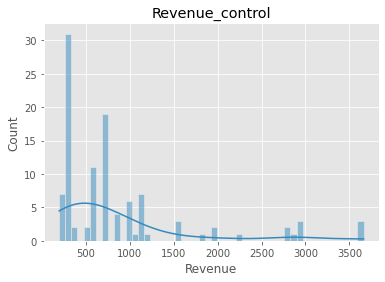

In [44]:
sns.histplot(
    df.query('Revenue>0').query('grp=="A"')['Revenue'],
    bins=50, kde=True).set_title("Revenue_control")

Text(0.5, 1.0, 'Revenue_target')

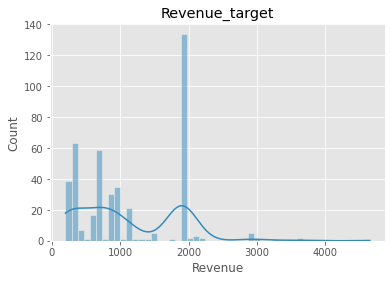

In [45]:
sns.histplot(
    df.query('Revenue>0').query('grp=="B"')['Revenue'],
    bins=50, kde=True).set_title("Revenue_target")

### 2. Имеются ли различия в показателях и с чем они могут быть связаны?

Различия метрик у целевой и контрольной группы:<br>
ARPPU выше у целевой группы (группа B, которой была предложена новая механика оплаты). На данном этапе анализа нельзя сказать, является ли это различие статистически значимым, т.е. новая механика оплаты действительно приводит к увеличению среднего чека, либо статистически незначимым, т.е. новая механика оплаты не приводит к изменению среднего чека и полученная разница случайна. Из визуализации выше видно, что увеличение ARPPU в целевой группе обусловлено большим количеством покупкого одного курса (или курсов в одном ценовом сегменте) - около 130 человек (из 434 сделавших покупку) купили курс стоимостью ~2000. Для целей анализа предполагаю, что новый механизм оплаты стимулировал пользователей купить востребованный/интересный  дорогой образовательный курс, который они бы не решились купить при базовом механизме оплаты. Возможны другие варианты:
* В период, когда тестировался новый механизм оплаты, проходила промоакция на какой-то определенный курс/ценовой сегмент курсов, что и вызвало повышенный спрос на курсы стоимостью ~2000;
* Была запущена рекламная компания, которая привела к увеличению количества посетителей платформы (количество пользователей платформы целевой группы почти в 4,5 раза больше контрольной группы);
* Период эксперимента с целевой группой выпал на "сезон/дни" повышенного спроса на образовательный контент.
    
Во всех этих случаях, проводить дальнейший анализ нет смысла, так как A/B тест спланирован некорректно, для целей дальнейшего анализа будем считать, что A/B тест спланирован корректно.
    
CR выше у контрольной группы (группа A, которой была предложена базовая механика оплаты). На данном этапе анализа нельзя сказать, является ли это различие статистически значимым или нет, т.е. действительно ли новая механика оплаты уменьшает конверсию в покупку или нет.

### 3. Являются ли эти различия статистически значимыми?

Сформулируем две пары гипотез.

1. Гипотезы об ARPPU:<br>
H0_1 - в генеральной совокупности никакого различия между показателями ARPPU нет, т.е. новая механика оплаты не приводит к изменению ARPPU;<br>
H1_1 - ARPPU в генеральной совокупности не равны (альтернативная гипотеза), т.е. новая механика оплаты приводит к изменению ARPPU;
2. Гипотезы об CR:<br>
H0_2- в генеральной совокупности никакого различия между показателями CR нет, т.е. новая механика оплаты не приводит к изменению CR;<br>
H1_2 - CR в генеральной совокупности не равны (альтернативная гипотеза), т.е. новая механика оплаты приводит к изменению CR;

#### Проверка гипотез об ARPPU

Исходя из визуализации и данных выше, видно, что распределение покупок среди пользователей не является нормальным и количество наблюдений в выборках разное. Для проверки статистическйо значимости различий в показателе ARPPU применим Бутстрап

#### Бутстрап

In [46]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

df_A = df.query('Revenue>0').query('grp=="A"')['Revenue']
df_B = df.query('Revenue>0').query('grp=="B"')['Revenue']

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    
# Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()   
      
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

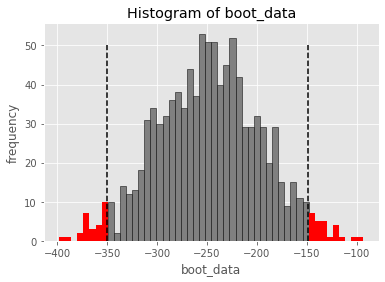

In [47]:
booted_data = get_bootstrap(df_A, df_B) # в результате хранится разница двух распределений, ДИ и pvalue

In [50]:
booted_data["p_value"] # альфа

1.2285720073164987e-06

In [51]:
booted_data["quants"] # ДИ

,0
0.025,-350.601738
0.975,-149.188546


#### Вывод:

В результате бутстрап выяснилось, что ARPPU в результате внедрения нового механизма оплаты уменьшился (отклоняем нулевую гипотезу, так как p-value меньше 0.05). Результаты теста противоречат первоначальному предположению о том, что ARPPU увеличилcя, так как на рассчитанное ранее ARPPU в целевой выборке повлияли "выбросы".

#### Проверка гипотез об CR

Для проверки статистическйо значимости различий в показателе CR применим метод Хи-квадрат

In [52]:
# Создадим таблицу сопряженности
table = np.array([ [df_1.query('grp=="A"').Total_users, df_1.query('grp=="A"').Paying_users],\
                [df_1.query('grp=="B"').Total_users, df_1.query('grp=="B"').Paying_users]  ])
# Применим метод Хи-квадрат
chi2, prob, df, expected = scipy.stats.chi2_contingency(table)
# Выведем p-value
print("p-value: {}".format(prob))

p-value: 0.4778925970224768


#### Вывод:

В результате анализа с Хи-квадрат выяснилось, что CR в результате внедрения нового механизма оплаты не изменился (принимаем нулевую гипотезу, так как p-value больше 0.05).

### 4. Стоит ли запускать новую механику на всех пользователей?

В результате анализа было выявлено, что новый механизм оплаты не приводит к изменению показателя CR и приводит к уменьшению показателя ARPPU. Можно сделать вывод о том, что не стоит запускать новую механику на всех пользователей.


# Задание 2. SQL

## 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### 2.1.2 Задача

Дана таблица <strong>default.peas</strong>:

<strong>st_id</strong> - ID ученика (тип - INT)<br>
<strong>timest</strong> - Время решения карточки (тип - timestamp)<br>
<strong>correct</strong> - Правильно ли решена горошина? (тип - bool)<br>
<strong>subject</strong> - Дисциплина, в которой находится горошина? (тип - text)<br>

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

NB! Под очень усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [53]:
# Cоздадим словарь connection с нужными параметрами для подключения к ClickHouse через pandahouse
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',\
                      'database':'default',\
                      'user':'student',\
                      'password':'dpo_python_2020' }

#### Подход к решению:

1. Так как в задании просят подсчитать количество студентов за текущий месяц, то из первоначальной базы данных нам нужно отобрать записи за текущий (последний) месяц (в предоставленной базе есть данные только за 1 месяц, запрос составляется с учетом того, что данные могут быть за несколько месяцев). В запросе q_1 добавим к исходным данным "Окно" с последним (текущим) месяцем - current_month.
2. В запросе q_2 отберем данные из запроса q_1 за последний месяц и подсчитаем количество правильно решенных горошин по студентам и оставим только тех, у кого количество правильно решенных горошин больше или равно 20.
3. Подсчитаем количество студентов из запроса q_2

In [54]:
# Создадим запрос
query = '''
    SELECT COUNT( DISTINCT st_id) as answer
    FROM
    
    (SELECT
        st_id,
        SUM(correct) as correct_tasks
    FROM

        (SELECT
            st_id,
            correct,
            toStartOfMonth(timest) as month,
            MAX(toStartOfMonth(timest)) OVER() AS current_month
        FROM
            default.peas) as q_1

    WHERE
        month=current_month
    GROUP BY
        st_id
    HAVING
        correct_tasks >= 20) as q_2               
'''
# Запишем результат запроса в пандасовский датафрейм
df_sql_1 = ph.read_clickhouse(query=query, connection=connection_default)

print("Количество очень усердных студентов: {}".format(df_sql_1['answer'][0]))

Количество очень усердных студентов: 136


## 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача
Дана таблицы: <strong>default.peas</strong> (см. выше), <strong>default.studs</strong>:

<strong>st_id</strong> - ID ученика (тип - INT)<br>
<strong>test_grp</strong> - Метка ученика в данном эксперименте (тип - text)<br>

и <strong>default.final_project_check</strong>:


<strong>st_id</strong> - ID ученика (тип - INT)<br>
<strong>sale_time</strong> - Время покупки (тип - timestamp)<br>
<strong>money</strong> - Цена, по которой приобрели данный курс? (тип - int)<br>
<strong>subject</strong> - Дисциплина, на которую приобрели полный доступ? (тип - text)<br>



Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU<br>
ARPAU - ARPU по активным пользователям<br>
CR в покупку<br> 
СR активного пользователя в покупку<br> 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике<br>

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

#### Подход к решению:

1. Шаг 1:<br>
1.1. Создадим вспомогательный подзапрос <strong>q_1</strong> из таблицы <strong>default.peas</strong> с данными по ID пользователя (st_id), дисциплинам (subject) и количеству правильно решенных горошин в целом по дисциплине (correct) и по математике (Math_correct);<br>
1.2. Создадим вспомогательный запрос <strong>Peas</strong> из подзапроса <strong>q_1</strong> с данными по ID пользователя (st_id) и инфо, явлется ли этот пользователь активным (Active) и является ли этот пользователь активным по математике (Active_math).<br>
2. Шаг 2. Создадим вспомогательный запрос <strong>Check</strong> из таблицы <strong>default.final_project_check</strong> с данными по ID пользователя (st_id), выручке в разрезе пользователей (revenue) и выручке от продажи курсов по математике в разрезе пользователей (Math_revenue).<br>
3. Шаг 3:<br>
3.1. Создадим вспомогательный подзапрос <strong>q_3</strong>, объединив данные таблицы <strong>default.studs</strong>, запросов <strong>Peas</strong> и <strong>Check</strong> с данными по ID пользователя (st_id), группе пользователя (test_grp), инфо, явлется ли этот пользователь активным (Active) и является ли этот пользователь активным по математике (Active_math), выручке в разрезе пользователей (revenue), инфо, явлется ли этот пользователь сконвертировавшимся в покупку (conversion_to_purchase) и явлется ли этот пользователь сконвертировавшимся в покупку курса по математике (conversion_to_math_purchase);<br>
3.2. На основе вспомогательного подзапроса <strong>q_3</strong> рассчитаем все необходимые метрики.

In [55]:
# Создадим запрос
query = '''

WITH

-- Шаг 1. Создадим вспомогательный запрос с данными по ID пользователя и инфо, явлется ли этот пользователь активным и является ли этот пользователь активным по математике

Peas AS

(SELECT
    st_id,
    IF(SUM(correct)>10,1,0) as Active, -- Поле, где 1 - это активный пользователь и 0 - не активный пользователь
    IF(SUM(Math_correct)>=2,1,0) as Active_math -- Поле, где 1 - это активный пользователь по математике и 0 - не активный пользователь по математике
FROM 

(
-- Создадим вспомогательный подзапрос с данными по ID пользователя, дисциплинам и количеству правильно решенных горошин в целом по дисциплине и по математике
    SELECT
            st_id,
            SUM(correct) as correct, -- Кол-во правильно решенных горошин в разрезе дисциплин и пользователей
            subject,
            (IF(subject='Math',1,0)*correct) as Math_correct -- Кол-во правильно решенных "горошин" по математике
    FROM
        default.peas
    GROUP BY
        st_id,
        subject           ) as q_1
        
GROUP BY st_id ),

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

-- Шаг 2. Создадим вспомогательный запрос с данными по ID пользователя, выручке в разрезе пользователей и выручке от продажи курсов по математике в разрезе пользователей   
   
Check AS   
   (SELECT
            st_id,
            SUM(money) as revenue, -- Выручка в разрезе пользователей
            SUMIf(money, subject = 'Math') as Math_revenue  -- Выручка в разрезе пользователей от продажи курсов по математике
            
    FROM
        default.final_project_check
    GROUP BY
        st_id)
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------        
-- Шаг 3

SELECT
    test_grp,
    ROUND(SUM(revenue)/COUNT(st_id),2) as ARPU,
    ROUND(SUM(revenue*Active)/SUM(Active),2) as ARPAU,
    ROUND(SUM(conversion_to_purchase)/COUNT(st_id),2) as CR,
    ROUND(SUM(conversion_to_purchase*Active)/SUM(Active),2) as CR_from_Active,
    ROUND(SUM(Active_math*conversion_to_math_purchase)/SUM(Active_math),2) as CR_from_Active_math
    
FROM       
        (SELECT
            s.st_id as st_id,
            s.test_grp as test_grp,
            p.Active as Active,
            p.Active_math as Active_math,
            c.revenue as revenue,
            IF(revenue>0,1,0) as conversion_to_purchase,
            IF(Math_revenue>0,1,0) as conversion_to_math_purchase
        FROM
           default.studs as s 
        LEFT JOIN
            Peas as p
        ON
           s.st_id = p.st_id 
        LEFT JOIN
            Check as c
        ON
           s.st_id = c.st_id ) as q_3
GROUP BY
    test_grp
       
'''
df_sql_2 = ph.read_clickhouse(query=query, connection=connection_default)
print("Ответ:")
df_sql_2

Ответ:


,test_grp,ARPU,ARPAU,CR,CR_from_Active,CR_from_Active_math
0,control,4540.98,10393.70,0.05,0.11,0.06
1,pilot,11508.47,29739.58,0.11,0.26,0.10


# Задание 3. Python

## 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

### 1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [56]:
# Создадим функцию
def metrics_calc(url):
    # Скачиваем исходные датасеты, по условию функци ядолжна подгружать дополнительные данные из файла groups_add.csv,
    #поэтому ссылку на него мы сделаем в качестве параметра функции
    groups = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/LIE6fUfbD7belQ', sep=';')
    groups_add = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url}')
    active_studs = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/9ExyNormZbelyg')
    checks = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/H-GJTo5Mx4Ld-g', sep=';')
    # Создадим объединенный датафрейм
    df_g = groups.append(groups_add, ignore_index=True).rename(columns={'id':'student_id'})
    df_c = active_studs.merge(checks, how='outer', on='student_id').fillna(0)
    df = df_c.merge(df_g, how='left', on='student_id').fillna(0).rename(columns={'rev':'Revenue'})
    # Создадим вспомогательный датафрейм для расчета метрик
    df_1 = df.query('Revenue>0').groupby('grp', as_index=False).sum()\
        .assign(Paying_users=df.query('Revenue>0').groupby('grp', as_index=False).count()['Revenue'])\
        .assign(Total_users=df.groupby('grp', as_index=False).count()['student_id'])
    # Рассчитаем метрики
    df_2 = df_1\
        .assign(ARPPU=(df_1['Revenue']/df_1['Paying_users']).round(2))\
        .assign(CR=(df_1['Paying_users']/df_1['Total_users']).round(3))\
        [['grp', 'ARPPU', 'CR']]
    return df_2
    

In [57]:
# Передадим в функцию адрес дополнительного файла
metrics = metrics_calc('https://disk.yandex.ru/d/qgQpmgvjemOJFw')
metrics

,grp,ARPPU,CR
0,A,860.71,0.068
1,B,1108.82,0.063


### 2. Реализуйте функцию, которая будет строить графики по получаемым метрикам

In [58]:
# Создадим функцию
def visualization(metrics_data):
    fig, ax = plt.subplots(1, 2)
    sns.barplot(ax=ax[1], data = metrics_data, x = 'grp', y = 'ARPPU', color = 'royalblue')\
                .set(xlabel='Groups', ylabel='', title = 'ARPPU')
    sns.barplot(ax=ax[0], data = metrics_data, x = 'grp', y = 'CR', color = 'royalblue')\
                .set(xlabel='Groups', ylabel='', title = 'CR')
    sns.despine()

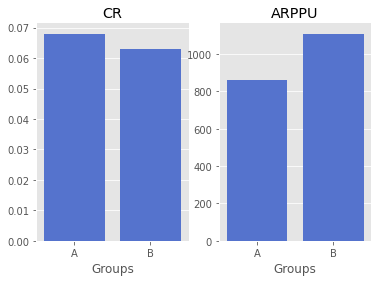

In [59]:
# Передадим в функцию рассчитанные ранее метрики
visualization(metrics)